# 04 — REINFORCE from Scratch: Implementing Policy Gradients for LLMs

> **Purpose:** This notebook builds your implementation intuition from first principles. We'll code the REINFORCE algorithm step-by-step, understand why it has high variance, add baselines, and evolve toward production patterns like GRPO.

**Prerequisites:** Understanding of Sections 1.1-1.3 (RL training loop, technical pillars, reward design)

---

## Part 1: The Log-Probability Trick — Why It Matters

### 1.1 The Core Problem

We want to maximize expected reward:

$$J(\theta) = \mathbb{E}_{y \sim \pi_\theta}[R(y)]$$

To use gradient descent, we need $\nabla_\theta J(\theta)$. But the expectation is over samples from $\pi_\theta$ — how do we differentiate through sampling?

### 1.2 The Log-Derivative Trick

The magic identity:

$$\nabla_\theta \pi_\theta(y) = \pi_\theta(y) \cdot \nabla_\theta \log \pi_\theta(y)$$

**Why this matters for LLMs:**
- An LLM generates a sequence of tokens: $y = (y_1, y_2, ..., y_T)$
- The probability of the sequence is a **product**: $\pi_\theta(y) = \prod_{t=1}^{T} \pi_\theta(y_t | y_{<t})$
- Products are numerically unstable (underflow to zero)
- Log converts products to **sums**: $\log \pi_\theta(y) = \sum_{t=1}^{T} \log \pi_\theta(y_t | y_{<t})$

### 1.3 The Policy Gradient Formula

Applying the trick:

$$\nabla_\theta J(\theta) = \mathbb{E}_{y \sim \pi_\theta}[R(y) \cdot \nabla_\theta \log \pi_\theta(y)]$$

In code, this becomes:
```python
loss = -log_prob * reward  # Negative because we minimize loss
loss.backward()            # PyTorch computes gradients
```

In [1]:
# Setup: Install dependencies if needed
# !pip install torch transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


## Part 2: A Toy Language Model

Before using HuggingFace models, let's build intuition with a tiny model.

**Task:** Generate sequences of 5 tokens from vocabulary of size 10. Reward = 1 if sequence sums to target, else 0.

This is analogous to:
- Math RL: Generate tokens → check if answer is correct
- Our "ground truth" is a simple arithmetic check

In [2]:
class TinyLM(nn.Module):
    """
    A minimal language model for teaching REINFORCE.
    - Hidden state summarizes sequence so far
    - Outputs probability distribution over vocabulary
    """
    def __init__(self, vocab_size=10, hidden_size=32, seq_length=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        
        # Embedding for each token
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        # RNN to process sequence
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
        # Output head: hidden -> vocab logits
        self.output_head = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, tokens, hidden=None):
        """
        Args:
            tokens: [batch_size, seq_len] - tokens generated so far
            hidden: [1, batch_size, hidden_size] - RNN hidden state
        Returns:
            logits: [batch_size, vocab_size] - next token logits
            hidden: updated hidden state
        """
        embeds = self.embedding(tokens)  # [batch, seq, hidden]
        output, hidden = self.rnn(embeds, hidden)
        logits = self.output_head(output[:, -1, :])  # Last position
        return logits, hidden
    
    def generate(self, batch_size=1, return_log_probs=False):
        """
        Autoregressively generate a sequence.
        
        Returns:
            tokens: [batch_size, seq_length] - generated tokens
            log_probs: [batch_size, seq_length] - log prob of each token (if requested)
        """
        device = next(self.parameters()).device
        
        # Start with token 0 (like <BOS>)
        tokens = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        hidden = None
        
        all_tokens = []
        all_log_probs = []
        
        for _ in range(self.seq_length):
            logits, hidden = self.forward(tokens, hidden)
            
            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            dist = Categorical(probs)
            next_token = dist.sample()  # [batch_size]
            
            # Store log probability of the sampled token
            log_prob = dist.log_prob(next_token)  # [batch_size]
            
            all_tokens.append(next_token)
            all_log_probs.append(log_prob)
            
            # Update input for next step
            tokens = next_token.unsqueeze(1)  # [batch, 1]
        
        tokens = torch.stack(all_tokens, dim=1)  # [batch, seq_length]
        log_probs = torch.stack(all_log_probs, dim=1)  # [batch, seq_length]
        
        if return_log_probs:
            return tokens, log_probs
        return tokens

# Test the model
model = TinyLM()
tokens, log_probs = model.generate(batch_size=4, return_log_probs=True)
print(f"Generated tokens:\n{tokens}")
print(f"\nLog probabilities:\n{log_probs}")
print(f"\nSum of log probs (sequence log prob): {log_probs.sum(dim=1)}")

Generated tokens:
tensor([[0, 7, 4, 5, 3],
        [2, 7, 5, 0, 4],
        [9, 4, 6, 4, 6],
        [4, 3, 3, 6, 6]])

Log probabilities:
tensor([[-2.2997, -2.2550, -1.8945, -2.2934, -2.3123],
        [-2.5492, -2.1488, -2.1985, -2.2115, -1.8776],
        [-2.5404, -2.0474, -2.2585, -2.1516, -2.1385],
        [-1.9272, -2.4421, -2.4539, -2.3123, -2.1818]],
       grad_fn=<StackBackward0>)

Sum of log probs (sequence log prob): tensor([-11.0550, -10.9857, -11.1363, -11.3172], grad_fn=<SumBackward1>)


### Key Insight: The `log_prob` Is What We Need!

The `dist.log_prob(token)` gives us $\log \pi_\theta(y_t | y_{<t})$.

The **sum** across all tokens gives us $\log \pi_\theta(y)$ — the log probability of the entire sequence.

This is connected to gradients via autograd: when we call `.backward()` on a function of `log_prob`, PyTorch automatically computes $\nabla_\theta \log \pi_\theta$.

In [3]:
def compute_reward(tokens, target_sum=25):
    """
    Binary reward: 1 if token sum equals target, else 0.
    This mimics math RL where we check if the answer is correct.
    
    Args:
        tokens: [batch_size, seq_length]
        target_sum: the target sum for success
    Returns:
        rewards: [batch_size] - 0 or 1 for each sequence
    """
    token_sums = tokens.sum(dim=1)  # [batch_size]
    rewards = (token_sums == target_sum).float()
    return rewards

# Test reward function
test_tokens = torch.tensor([
    [5, 5, 5, 5, 5],   # sum = 25 → reward = 1
    [1, 2, 3, 4, 5],   # sum = 15 → reward = 0
    [9, 9, 7, 0, 0],   # sum = 25 → reward = 1
])
rewards = compute_reward(test_tokens, target_sum=25)
print(f"Tokens:\n{test_tokens}")
print(f"Sums: {test_tokens.sum(dim=1)}")
print(f"Rewards: {rewards}")

Tokens:
tensor([[5, 5, 5, 5, 5],
        [1, 2, 3, 4, 5],
        [9, 9, 7, 0, 0]])
Sums: tensor([25, 15, 25])
Rewards: tensor([1., 0., 1.])


## Part 3: Vanilla REINFORCE

The simplest policy gradient algorithm:

$$\nabla_\theta J \approx \frac{1}{N} \sum_{i=1}^{N} R(y_i) \cdot \nabla_\theta \log \pi_\theta(y_i)$$

In code:
```python
loss = -(log_probs.sum(dim=1) * rewards).mean()
```

**The intuition:**
- If reward is high → increase log_prob → increase probability of this sequence
- If reward is low → barely update (multiplied by small reward)
- Negative sign: we minimize loss, which maximizes reward

In [4]:
def train_vanilla_reinforce(model, num_episodes=500, batch_size=64, lr=0.01, target_sum=25):
    """
    Train using vanilla REINFORCE.
    
    Returns history of rewards for plotting.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    reward_history = []
    
    for episode in range(num_episodes):
        # Generate batch of sequences
        tokens, log_probs = model.generate(batch_size=batch_size, return_log_probs=True)
        
        # Compute rewards
        rewards = compute_reward(tokens, target_sum=target_sum)
        
        # REINFORCE loss: -log_prob * reward
        # Sum log_probs across sequence (log of product = sum of logs)
        sequence_log_probs = log_probs.sum(dim=1)  # [batch_size]
        
        # Policy gradient loss
        loss = -(sequence_log_probs * rewards).mean()
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track progress
        mean_reward = rewards.mean().item()
        reward_history.append(mean_reward)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Mean reward = {mean_reward:.3f}, Loss = {loss.item():.4f}")
    
    return reward_history

# Train!
model_vanilla = TinyLM()
history_vanilla = train_vanilla_reinforce(model_vanilla, num_episodes=500)

Episode 0: Mean reward = 0.094, Loss = 1.0667
Episode 50: Mean reward = 0.531, Loss = 0.9350
Episode 100: Mean reward = 1.000, Loss = 0.0027
Episode 150: Mean reward = 1.000, Loss = 0.0017
Episode 200: Mean reward = 1.000, Loss = 0.0012
Episode 250: Mean reward = 1.000, Loss = 0.0009
Episode 300: Mean reward = 1.000, Loss = 0.0007
Episode 350: Mean reward = 1.000, Loss = 0.0009
Episode 400: Mean reward = 1.000, Loss = 0.0006
Episode 450: Mean reward = 1.000, Loss = 0.0004


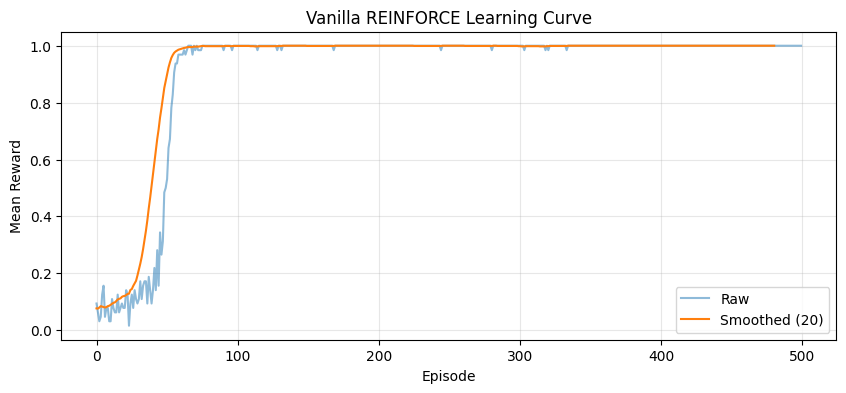

In [5]:
# Plot learning curve
plt.figure(figsize=(10, 4))
plt.plot(history_vanilla, alpha=0.5, label='Raw')
plt.plot(np.convolve(history_vanilla, np.ones(20)/20, mode='valid'), label='Smoothed (20)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Vanilla REINFORCE Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 🚨 Observe the Variance!

Notice how noisy the learning curve is. This is the **high variance problem** of vanilla REINFORCE.

**Why?**
- With binary rewards (0 or 1), most samples get reward 0
- When we get a reward of 1, we increase probability of that sequence
- But we're not decreasing probability of bad sequences (they contribute 0 to gradient)
- Random chance determines which sequences we sample → high variance

---

## Part 4: Adding a Baseline (Variance Reduction)

The key insight: we can subtract any constant $b$ (baseline) from the reward without changing the expected gradient:

$$\nabla_\theta J = \mathbb{E}[(R - b) \cdot \nabla_\theta \log \pi_\theta]$$

**Why this works mathematically:**
$$\mathbb{E}[b \cdot \nabla_\theta \log \pi_\theta] = b \cdot \mathbb{E}[\nabla_\theta \log \pi_\theta] = b \cdot \nabla_\theta \mathbb{E}[1] = b \cdot 0 = 0$$

**Why this helps:**
- Set $b = \mathbb{E}[R]$ (mean reward)
- Now sequences above average get positive advantage → probability increases
- Sequences below average get negative advantage → probability decreases
- We're pushing up good sequences AND pushing down bad ones!

In [6]:
def train_reinforce_with_baseline(model, num_episodes=500, batch_size=64, lr=0.01, target_sum=25):
    """
    REINFORCE with a simple baseline: mean reward of the batch.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    reward_history = []
    
    for episode in range(num_episodes):
        tokens, log_probs = model.generate(batch_size=batch_size, return_log_probs=True)
        rewards = compute_reward(tokens, target_sum=target_sum)
        
        sequence_log_probs = log_probs.sum(dim=1)
        
        # === THE KEY CHANGE: Compute advantage ===
        baseline = rewards.mean()  # Simple baseline: batch mean
        advantages = rewards - baseline  # Can be positive or negative!
        
        # Now we use advantages instead of raw rewards
        loss = -(sequence_log_probs * advantages).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_reward = rewards.mean().item()
        reward_history.append(mean_reward)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Mean reward = {mean_reward:.3f}, Baseline = {baseline:.3f}")
    
    return reward_history

# Train with baseline
model_baseline = TinyLM()
history_baseline = train_reinforce_with_baseline(model_baseline, num_episodes=500)

Episode 0: Mean reward = 0.031, Baseline = 0.031
Episode 50: Mean reward = 0.953, Baseline = 0.953
Episode 100: Mean reward = 1.000, Baseline = 1.000
Episode 150: Mean reward = 1.000, Baseline = 1.000
Episode 200: Mean reward = 1.000, Baseline = 1.000
Episode 250: Mean reward = 0.984, Baseline = 0.984
Episode 300: Mean reward = 1.000, Baseline = 1.000
Episode 350: Mean reward = 1.000, Baseline = 1.000
Episode 400: Mean reward = 1.000, Baseline = 1.000
Episode 450: Mean reward = 1.000, Baseline = 1.000


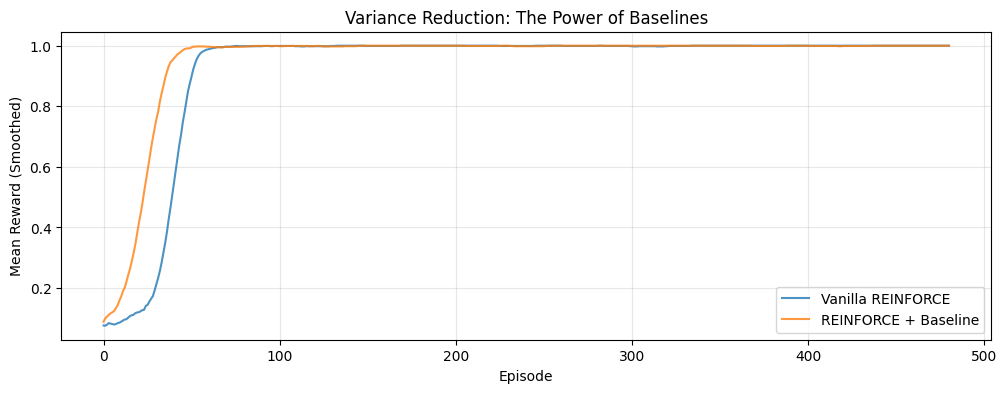

In [7]:
# Compare vanilla vs baseline
plt.figure(figsize=(12, 4))

window = 20
plt.plot(np.convolve(history_vanilla, np.ones(window)/window, mode='valid'), 
         label='Vanilla REINFORCE', alpha=0.8)
plt.plot(np.convolve(history_baseline, np.ones(window)/window, mode='valid'), 
         label='REINFORCE + Baseline', alpha=0.8)

plt.xlabel('Episode')
plt.ylabel('Mean Reward (Smoothed)')
plt.title('Variance Reduction: The Power of Baselines')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part 5: Group-Relative Advantages (GRPO Style)

This is how DeepSeek's GRPO works:

1. For each prompt, generate **K completions**
2. Compute reward for each completion
3. Each completion's advantage = its reward - mean reward of the group

**Why this is better than batch mean:**
- Compares responses to the **same prompt**
- Intra-prompt competition: "which of YOUR K attempts was best?"
- More stable signal than batch-global comparison

In [8]:
def train_grpo_style(model, num_episodes=500, num_prompts=16, k_completions=4, 
                     lr=0.01, target_sum=25):
    """
    GRPO-style training: K completions per prompt, group-relative advantages.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    reward_history = []
    
    for episode in range(num_episodes):
        all_log_probs = []
        all_advantages = []
        all_rewards = []
        
        # For each "prompt" (in our toy case, just different random seeds)
        for prompt_idx in range(num_prompts):
            # Generate K completions
            tokens, log_probs = model.generate(
                batch_size=k_completions, 
                return_log_probs=True
            )
            rewards = compute_reward(tokens, target_sum=target_sum)
            
            # Group-relative advantage: subtract group mean
            group_mean = rewards.mean()
            advantages = rewards - group_mean
            
            sequence_log_probs = log_probs.sum(dim=1)
            
            all_log_probs.append(sequence_log_probs)
            all_advantages.append(advantages)
            all_rewards.append(rewards)
        
        # Combine all prompts
        all_log_probs = torch.cat(all_log_probs)
        all_advantages = torch.cat(all_advantages)
        all_rewards = torch.cat(all_rewards)
        
        # Policy gradient loss with group-relative advantages
        loss = -(all_log_probs * all_advantages).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_reward = all_rewards.mean().item()
        reward_history.append(mean_reward)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Mean reward = {mean_reward:.3f}")
    
    return reward_history

# Train GRPO-style
model_grpo = TinyLM()
history_grpo = train_grpo_style(model_grpo, num_episodes=500)

Episode 0: Mean reward = 0.078
Episode 50: Mean reward = 0.953
Episode 100: Mean reward = 1.000
Episode 150: Mean reward = 1.000
Episode 200: Mean reward = 1.000
Episode 250: Mean reward = 1.000
Episode 300: Mean reward = 1.000
Episode 350: Mean reward = 1.000
Episode 400: Mean reward = 1.000
Episode 450: Mean reward = 1.000


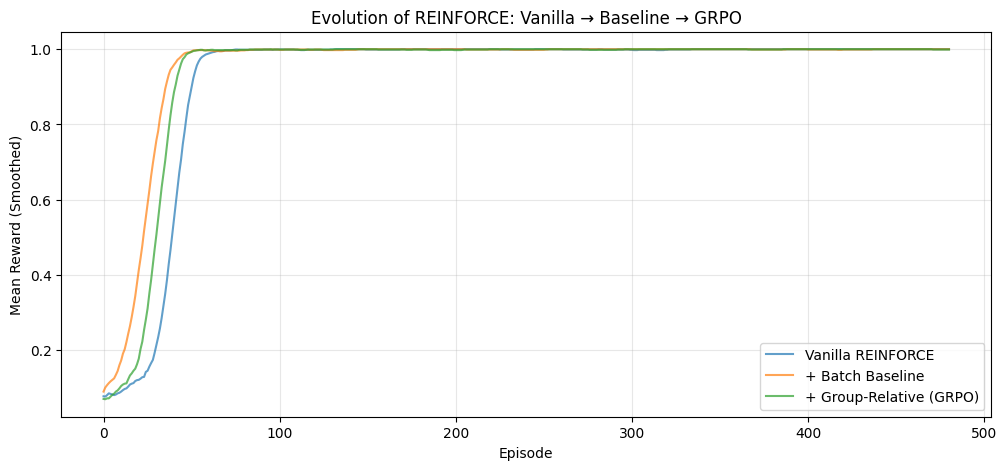

In [9]:
# Compare all three methods
plt.figure(figsize=(12, 5))

window = 20
plt.plot(np.convolve(history_vanilla, np.ones(window)/window, mode='valid'), 
         label='Vanilla REINFORCE', alpha=0.7)
plt.plot(np.convolve(history_baseline, np.ones(window)/window, mode='valid'), 
         label='+ Batch Baseline', alpha=0.7)
plt.plot(np.convolve(history_grpo, np.ones(window)/window, mode='valid'), 
         label='+ Group-Relative (GRPO)', alpha=0.7)

plt.xlabel('Episode')
plt.ylabel('Mean Reward (Smoothed)')
plt.title('Evolution of REINFORCE: Vanilla → Baseline → GRPO')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Part 6: The Hybrid Normalization Fix

GRPO has a critical flaw: when all K completions have the same reward (e.g., all correct = 1), the group mean equals each reward, so advantages = 0.

**The problem:** Easy data → all correct → zero gradients → no learning!

**The fix (from Tricks or Traps):**
- Use **group mean** for centering (intra-prompt competition)
- Use **batch standard deviation** for scaling (cross-prompt stability)

In [10]:
def train_hybrid_normalization(model, num_episodes=500, num_prompts=16, k_completions=4,
                                lr=0.01, target_sum=25):
    """
    Hybrid normalization: group mean + batch std (the production fix).
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    reward_history = []
    
    for episode in range(num_episodes):
        all_log_probs = []
        all_rewards = []
        group_means = []
        
        # Collect all data
        for prompt_idx in range(num_prompts):
            tokens, log_probs = model.generate(
                batch_size=k_completions, 
                return_log_probs=True
            )
            rewards = compute_reward(tokens, target_sum=target_sum)
            
            group_means.append(rewards.mean())
            all_log_probs.append(log_probs.sum(dim=1))
            all_rewards.append(rewards)
        
        # Combine
        all_log_probs = torch.cat(all_log_probs)
        all_rewards = torch.cat(all_rewards)
        
        # Compute group-level advantages (centered by group mean)
        centered_rewards = []
        for i, rewards in enumerate(all_rewards.reshape(num_prompts, k_completions)):
            centered_rewards.append(rewards - group_means[i])
        centered_rewards = torch.cat(centered_rewards)
        
        # === HYBRID: Normalize by BATCH std, not group std ===
        batch_std = all_rewards.std() + 1e-8  # Avoid division by zero
        advantages = centered_rewards / batch_std
        
        # Policy gradient loss
        loss = -(all_log_probs * advantages).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_reward = all_rewards.mean().item()
        reward_history.append(mean_reward)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Mean reward = {mean_reward:.3f}, Batch std = {batch_std:.3f}")
    
    return reward_history

# Train with hybrid normalization
model_hybrid = TinyLM()
history_hybrid = train_hybrid_normalization(model_hybrid, num_episodes=500)

Episode 0: Mean reward = 0.016, Batch std = 0.125
Episode 50: Mean reward = 0.938, Batch std = 0.244
Episode 100: Mean reward = 1.000, Batch std = 0.000
Episode 150: Mean reward = 1.000, Batch std = 0.000
Episode 200: Mean reward = 1.000, Batch std = 0.000
Episode 250: Mean reward = 1.000, Batch std = 0.000
Episode 300: Mean reward = 1.000, Batch std = 0.000
Episode 350: Mean reward = 1.000, Batch std = 0.000
Episode 400: Mean reward = 1.000, Batch std = 0.000
Episode 450: Mean reward = 1.000, Batch std = 0.000


## Part 7: Adding PPO-Style Clipping

The final piece: prevent the policy from changing too much in a single update.

**The probability ratio:**
$$r_t = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$$

**The clipped objective:**
$$L^{CLIP} = \min(r_t \cdot A_t, \text{clip}(r_t, 1-\epsilon, 1+\epsilon) \cdot A_t)$$

This prevents catastrophic policy updates.

In [11]:
def compute_log_prob_for_tokens(model, tokens):
    """
    Compute log probabilities for a given sequence of tokens.
    Used to compute the probability ratio for PPO.
    """
    batch_size, seq_len = tokens.shape
    device = next(model.parameters()).device
    
    # Start token
    current_tokens = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
    hidden = None
    
    all_log_probs = []
    
    for t in range(seq_len):
        logits, hidden = model.forward(current_tokens, hidden)
        probs = F.softmax(logits, dim=-1)
        dist = Categorical(probs)
        
        # Log prob of the ACTUAL token that was generated
        log_prob = dist.log_prob(tokens[:, t])
        all_log_probs.append(log_prob)
        
        # Feed the actual token for next step
        current_tokens = tokens[:, t:t+1]
    
    return torch.stack(all_log_probs, dim=1).sum(dim=1)  # [batch_size]

def train_ppo_style(model, num_episodes=500, num_prompts=16, k_completions=4,
                    lr=0.01, clip_epsilon=0.2, target_sum=25):
    """
    PPO-style training with clipped ratio.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    reward_history = []
    
    for episode in range(num_episodes):
        # === PHASE 1: Collect data with old policy ===
        all_tokens = []
        all_old_log_probs = []
        all_rewards = []
        group_means = []
        
        with torch.no_grad():
            for prompt_idx in range(num_prompts):
                tokens, log_probs = model.generate(
                    batch_size=k_completions, 
                    return_log_probs=True
                )
                rewards = compute_reward(tokens, target_sum=target_sum)
                
                all_tokens.append(tokens)
                all_old_log_probs.append(log_probs.sum(dim=1))
                all_rewards.append(rewards)
                group_means.append(rewards.mean())
        
        all_tokens = torch.cat(all_tokens)
        all_old_log_probs = torch.cat(all_old_log_probs)
        all_rewards_flat = torch.cat(all_rewards)
        
        # Compute advantages with hybrid normalization
        centered = []
        for i, rewards in enumerate(all_rewards):
            centered.append(rewards - group_means[i])
        advantages = torch.cat(centered)
        batch_std = all_rewards_flat.std() + 1e-8
        advantages = advantages / batch_std
        
        # === PHASE 2: Update with clipped objective ===
        # Compute NEW log probs for the same tokens
        new_log_probs = compute_log_prob_for_tokens(model, all_tokens)
        
        # Probability ratio
        ratio = torch.exp(new_log_probs - all_old_log_probs)
        
        # Clipped objective
        unclipped = ratio * advantages
        clipped = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
        
        # Take the minimum (pessimistic bound)
        loss = -torch.min(unclipped, clipped).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        mean_reward = all_rewards_flat.mean().item()
        reward_history.append(mean_reward)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Mean reward = {mean_reward:.3f}, Mean ratio = {ratio.mean():.3f}")
    
    return reward_history

# Train PPO-style
model_ppo = TinyLM()
history_ppo = train_ppo_style(model_ppo, num_episodes=500)

Episode 0: Mean reward = 0.047, Mean ratio = 1.000
Episode 50: Mean reward = 0.984, Mean ratio = 1.000
Episode 100: Mean reward = 1.000, Mean ratio = 1.000
Episode 150: Mean reward = 1.000, Mean ratio = 1.000
Episode 200: Mean reward = 1.000, Mean ratio = 1.000
Episode 250: Mean reward = 1.000, Mean ratio = 1.000
Episode 300: Mean reward = 1.000, Mean ratio = 1.000
Episode 350: Mean reward = 1.000, Mean ratio = 1.000
Episode 400: Mean reward = 1.000, Mean ratio = 1.000
Episode 450: Mean reward = 1.000, Mean ratio = 1.000


## Part 8: The Complete Pipeline

Let's put it all together in a clean class that mirrors production code:

```
REINFORCE++/Lite PPO = 
    REINFORCE 
    + Group-relative advantages (local mean)
    + Batch normalization (global std)
    + Probability ratio clipping
```

In [12]:
class REINFORCEppTrainer:
    """
    Production-style REINFORCE++ / Lite PPO trainer.
    
    Implements:
    - Group-relative advantages (GRPO-style)
    - Hybrid normalization (group mean + batch std)
    - PPO-style clipping
    - Token-level loss aggregation
    """
    
    def __init__(self, model, lr=0.01, clip_epsilon=0.2, 
                 num_prompts=16, k_completions=4):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.clip_epsilon = clip_epsilon
        self.num_prompts = num_prompts
        self.k_completions = k_completions
        
    def collect_rollouts(self, reward_fn):
        """
        Generate completions and compute rewards.
        Returns tokens, log_probs, rewards, advantages.
        """
        all_tokens = []
        all_log_probs = []
        all_rewards = []
        group_means = []
        
        with torch.no_grad():
            for _ in range(self.num_prompts):
                tokens, log_probs = self.model.generate(
                    batch_size=self.k_completions,
                    return_log_probs=True
                )
                rewards = reward_fn(tokens)
                
                all_tokens.append(tokens)
                all_log_probs.append(log_probs)  # Keep token-level
                all_rewards.append(rewards)
                group_means.append(rewards.mean())
        
        # Flatten
        all_tokens = torch.cat(all_tokens)  # [N, seq_len]
        all_log_probs = torch.cat(all_log_probs)  # [N, seq_len]
        all_rewards_flat = torch.cat(all_rewards)  # [N]
        
        # Compute advantages with hybrid normalization
        centered = []
        for i, rewards in enumerate(all_rewards):
            centered.append(rewards - group_means[i])
        advantages = torch.cat(centered)
        batch_std = all_rewards_flat.std() + 1e-8
        advantages = advantages / batch_std
        
        return all_tokens, all_log_probs, all_rewards_flat, advantages
    
    def compute_loss(self, tokens, old_log_probs, advantages):
        """
        Compute PPO-style clipped loss.
        
        Uses TOKEN-LEVEL loss aggregation (each token contributes equally).
        """
        # Get new log probs
        batch_size, seq_len = tokens.shape
        device = next(self.model.parameters()).device
        
        current_tokens = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        hidden = None
        
        total_loss = 0.0
        
        for t in range(seq_len):
            logits, hidden = self.model.forward(current_tokens, hidden)
            probs = F.softmax(logits, dim=-1)
            dist = Categorical(probs)
            
            new_log_prob = dist.log_prob(tokens[:, t])
            old_log_prob = old_log_probs[:, t]
            
            # Ratio at this token
            ratio = torch.exp(new_log_prob - old_log_prob)
            
            # Clipped loss for this token
            # Note: same advantage for all tokens in sequence (response-level reward)
            unclipped = ratio * advantages
            clipped = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
            
            token_loss = -torch.min(unclipped, clipped).mean()
            total_loss += token_loss
            
            current_tokens = tokens[:, t:t+1]
        
        # Token-level: divide by number of tokens
        return total_loss / seq_len
    
    def train_step(self, reward_fn):
        """
        One training step.
        """
        # Collect data
        tokens, log_probs, rewards, advantages = self.collect_rollouts(reward_fn)
        
        # Compute loss
        loss = self.compute_loss(tokens, log_probs, advantages)
        
        # Update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return {
            'loss': loss.item(),
            'mean_reward': rewards.mean().item(),
            'reward_std': rewards.std().item()
        }

# Train with our complete trainer
model_complete = TinyLM()
trainer = REINFORCEppTrainer(model_complete, lr=0.01)

reward_fn = lambda tokens: compute_reward(tokens, target_sum=25)

history_complete = []
for episode in range(500):
    metrics = trainer.train_step(reward_fn)
    history_complete.append(metrics['mean_reward'])
    
    if episode % 50 == 0:
        print(f"Episode {episode}: {metrics}")

Episode 0: {'loss': -1.862645149230957e-09, 'mean_reward': 0.09375, 'reward_std': 0.29378482699394226}
Episode 50: {'loss': 0.0, 'mean_reward': 0.65625, 'reward_std': 0.4787135422229767}
Episode 100: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 150: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 200: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 250: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 300: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 350: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 400: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}
Episode 450: {'loss': 0.0, 'mean_reward': 1.0, 'reward_std': 0.0}


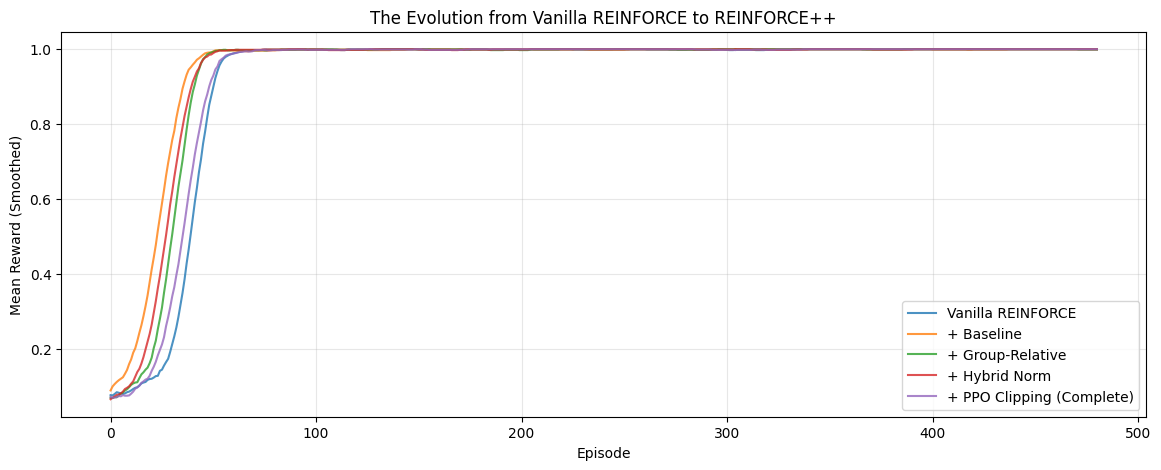

In [13]:
# Final comparison
plt.figure(figsize=(14, 5))

window = 20
methods = [
    (history_vanilla, 'Vanilla REINFORCE'),
    (history_baseline, '+ Baseline'),
    (history_grpo, '+ Group-Relative'),
    (history_hybrid, '+ Hybrid Norm'),
    (history_complete, '+ PPO Clipping (Complete)')
]

for hist, label in methods:
    smoothed = np.convolve(hist, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=label, alpha=0.8)

plt.xlabel('Episode')
plt.ylabel('Mean Reward (Smoothed)')
plt.title('The Evolution from Vanilla REINFORCE to REINFORCE++')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary: What We Built

| Component | Purpose | Code Pattern |
|-----------|---------|-------------|
| Log-prob extraction | Enable gradient through sampling | `dist.log_prob(token)` |
| Vanilla REINFORCE | Basic policy gradient | `loss = -(log_prob * reward).mean()` |
| Baseline | Reduce variance | `advantage = reward - baseline` |
| Group-relative | Intra-prompt competition | `adv = reward - group_mean` |
| Hybrid norm | Fix easy-data collapse | `adv = (r - group_mean) / batch_std` |
| PPO clipping | Stable updates | `min(ratio*adv, clip(ratio)*adv)` |

### Next Steps

1. **Section 2.2:** Apply this to a real HuggingFace model
2. **Section 2.3:** Add KL penalty for reward hacking prevention
3. **Section 2.4:** Full GRPO implementation with reference model